In [3]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath
import auxiliary_library as me

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, suppress=True, formatter={"float":lambda x: str(.001*int(1000*x))})

In [4]:
N=2; chain_type = "XYZ"; k_B = 1; temp = 2e-1

### ConstrucciÃ³n de los operadores
spin_ops_list = me.one_body_spin_ops(N)
identity_op = spin_ops_list[0][0]
ts = np.linspace(0, 5.,500)  

### Heisenberg Hamiltonian
Hamiltonian_paras = [.2, .15, .1, 1.]
H_H = me.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = False)

### classical operators 

cl_ops, label_ops = me.classical_ops(H_H, N, spin_ops_list, False)
magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

cl_ops["magnetization"] = magnetization; label_ops.append("magnetization")
cl_ops["neel_op"] = neel_operator; label_ops.append("neel_op")
print("Are all the operators Hermitian?:", me.basis_hermitian_check(cl_ops))

Are all the operators Hermitian?: [True, True, True, True, True, True, True, True, True, True]


In [ ]:
### Approved

def process_multiple_proj_evs(init_coeff_list,
                              timespan, 
                              range_temps, 
                              process_different_ref_temps = False):
    
    if process_different_ref_temps:
        depth_and_seed_ops = [(1, cl_ops["identity_op"]), 
                              (1, H_H), 
                              (4, spin_ops_list[1][0]),
                             ]
        labels = ["Temp_" + str(i) for i in range(len(range_temps))]
        observables = list(cl_ops.values())
        
        mutiple_ev_results = {}
        multiple_init_configs = {}; multiple_evs_data = {}; multiple_dict_res_proj_ev = {}; multiple_res_exact = {}
        
        for Temp_Ref in range_temps:
            print("Processing step: ", range_temps.index(Temp_Ref), "and temperature ", Temp_Ref)
            
            loc_coeff_list = init_coeff_list
            
            beta_ref = (1/Temp_Ref)
            K_ref = - beta_ref * .5 * spin_ops_list[1][0]
            rho_ref = (K_ref).expm()
            custom_rho_ref = rho_ref/rho_ref.tr()
            
            assert is_density_op(custom_rho_ref), "Error: rho_ref is not a density operator"
            
            init_configs_MFT_state, evs_data, dict_res_proj_ev, res_exact = d_depth_proj_ev(
                temp_ref = Temp_Ref, temp_rho = temp, 
                timespan = timespan, 
                Hamiltonian = H_H, lagrange_op = None,
                depth_and_seed_ops = depth_and_seed_ops, observables = observables, 
                label_ops = label_ops, coeff_list = loc_coeff_list, 
                custom_ref_state = custom_rho_ref, 
                rho_ref_thermal_state = False,
                rho_ref_equal_rho0 = False, visualize_H_evs = False, 
                visualization_nonherm = False, visualize_expt_vals = False, visualize_diff_expt_vals = False
                )
            
            multiple_init_configs["init_configs_T" + str(range_temps.index(Temp_Ref))] = init_configs_MFT_state
            multiple_evs_data["evs_data_T" + str(range_temps.index(Temp_Ref))] = evs_data
            multiple_dict_res_proj_ev["dict_res_proj_ev_T" + str(range_temps.index(Temp_Ref))] = dict_res_proj_ev
            multiple_res_exact["res_exact_T" + str(range_temps.index(Temp_Ref))] = res_exact
                        
        mutiple_ev_results["init_configs_all"] = multiple_init_configs
        mutiple_ev_results["evs_data_all"] = multiple_evs_data
        mutiple_ev_results["dict_res_proj_ev_all"] = multiple_dict_res_proj_ev
        mutiple_ev_results["res_exact_all"] = multiple_res_exact
            
        return mutiple_ev_results
    
### APPROVED
def plot_exact_v_proj_ev_avgs_multiple(obs, labels, timespan, no_cols_desired,
                                                     multiple_evolutions,
                                                     range_temps, 
                                                     visualize_diff_expt_vals = False):
    
    Tot = len(obs); Cols = no_cols_desired
    Rows = Tot // Cols 
    if Tot % Cols != 0:
        Rows += 1
    Position = range(1,Tot + 1)
    z = timespan[:-1]
    fig = plt.figure(figsize=(24, 14))
    range_temps_labels = [i for i in range(len(range_temps))]
    for k in range(Tot):
        ax = fig.add_subplot(Rows, Cols, Position[k])
        for T in range_temps:
            ax.plot(z, multiple_ev_results["dict_res_proj_ev_all"]["dict_res_proj_ev_T" + str(range_temps.index(T))]["Avgs"][k],
                    label = "Proj_ev.T=" + str(T))
            ax.plot(z, multiple_ev_results["res_exact_all"]["res_exact_T" + str(range_temps.index(T))].expect[k][:-1],
                    label = "Ex_evT=" + str(T))
        ax.legend(loc=0)
        ax.set_title("Expected values: Proj-ev. v. Exact for " + labels[k])   
    plt.show()
    
### APPROVED
def exact_v_proj_ev_matrix_metrics_multiple(timespan, range_temps, multiple_evolutions):
    
    z = timespan[:-1]
    bures_Ex_v_Proj_all = {}
    relEntropy_Ex_v_Proj_all = {}
    relEntropy_Proj_v_Ex_all = {}
    
    for T in range_temps: 
        rhot_list = multiple_ev_results["dict_res_proj_ev_all"]["dict_res_proj_ev_T" + str(range_temps.index(T))]["State_ev"]
        sigmat_list = multiple_ev_results["res_exact_all"]["res_exact_T" + str(range_temps.index(T))].states[:-1]
        
        bures_Ex_v_Proj_all["T" + str(range_temps.index(T))] = bures_vectorized(rhot_list = rhot_list,
                                                                                   sigmat_list = sigmat_list)
        local = relative_entropies_vectorized (rhot_list = rhot_list, sigmat_list = sigmat_list)
        relEntropy_Proj_v_Ex_all["T" + str(range_temps.index(T))] = local[0]
        relEntropy_Ex_v_Proj_all["T" + str(range_temps.index(T))] = local[1]
        rhot_list = None; sigmat_list = None
    
    return bures_Ex_v_Proj_all, relEntropy_Ex_v_Proj_all, relEntropy_Proj_v_Ex_all

### APPROVED
def plot_exact_v_proj_ev_metrics_multiple(timespan, range_temps, multiple_evolutions):
    
    label_metric = ["Bures Exact v. Proj ev", "S(exact || proj_ev)", "S(proj_ev || exact)"]
    metric_local = exact_v_proj_ev_matrix_metrics_multiple(timespan = timespan, 
                                                           range_temps = range_temps, 
                                                           multiple_evolutions = multiple_evolutions)
    Tot = len(label_metric); Cols = 3
    Rows = Tot // Cols 
    if Tot % Cols != 0:
        Rows += 1
    Position = range(1,Tot + 1)
    z = ts[:-1]
    fig = plt.figure(figsize=(10, 5))
    for k in range(Tot):
        ax = fig.add_subplot(Rows,Cols,Position[k])
        for T in range_temps:
            ax.plot(z, metric_local[k]["T"+str(range_temps.index(T))], label = "Exact v. Proj ev: " + label_metric[k])
            ax.legend(loc=0)
        ax.set_title("Matrix metrics")
    plt.show()    

In [6]:
timespan = np.linspace(0, 10, 100)
coeff_list = [0, 0., .5, .0, .0, .0] 
range_temps = [2e-1 * 2**i for i in range(4)]

multiple_ev_results = me.process_multiple_proj_evs(init_coeff_list = coeff_list, timespan = ts,
                                                range_temps = range_temps,
                                                process_different_ref_temps = True)

Processing step:  0 and temperature  0.2
1. Processing reference state ===>
^^##. custom reference state chosen
2. using a base of size  6
3. rho_ref:  Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.249 0.0 -0.212 0.0]
 [0.0 0.249 0.0 -0.212]
 [-0.212 0.0 0.25 0.0]
 [0.0 -0.212 0.0 0.25]]
The basis is orthonormal and hermitian
3. constructing rho0 from the coeff. list and orth. basis
Processing step:  1 and temperature  0.4
1. Processing reference state ===>
^^##. custom reference state chosen
2. using a base of size  6
3. rho_ref:  Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.249 0.0 -0.138 0.0]
 [0.0 0.249 0.0 -0.138]
 [-0.138 0.0 0.25 0.0]
 [0.0 -0.138 0.0 0.25]]
The basis is orthonormal and hermitian
3. constructing rho0 from the coeff. list and orth. basis
Processing step:  2 and temperature  0.8
1. Processing reference state ===>
^^##. custom reference state chosen
2. using

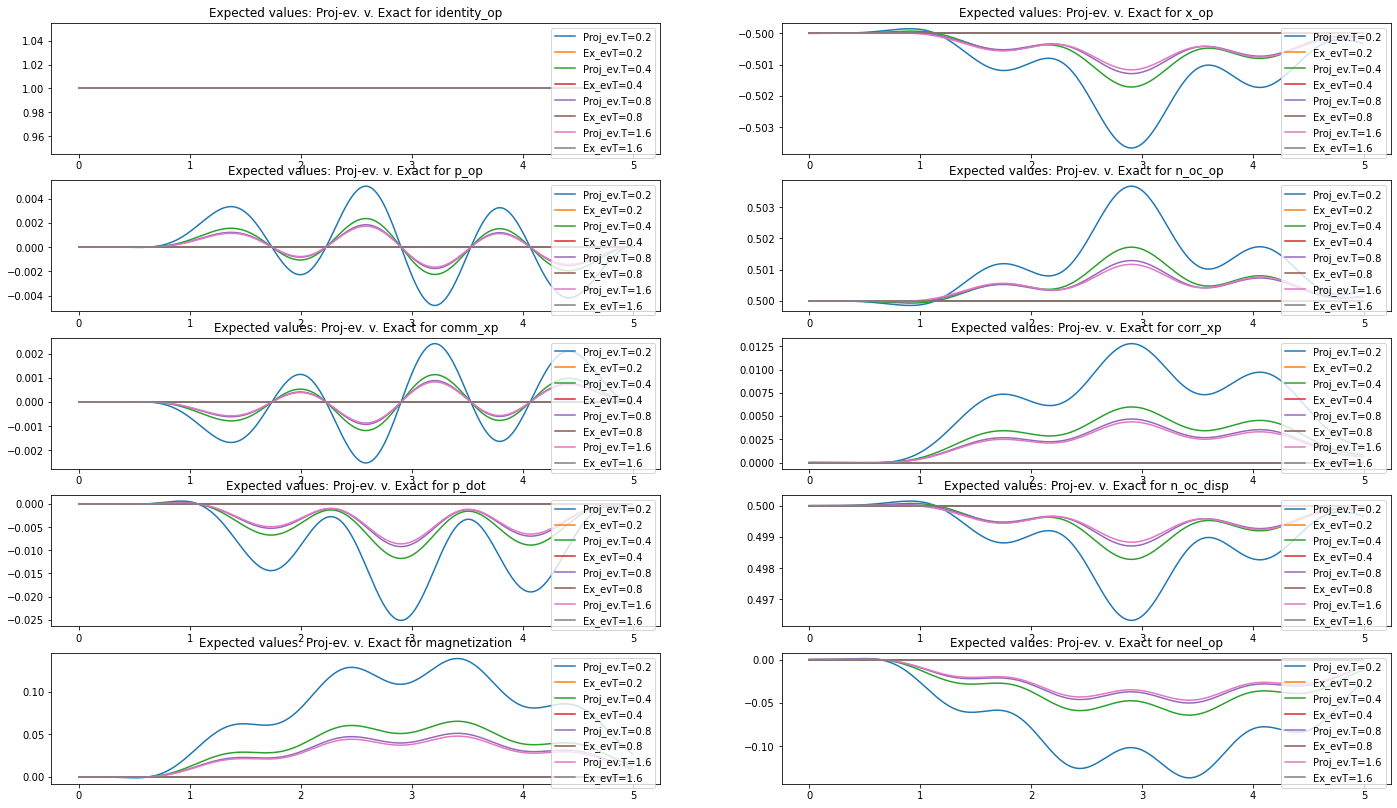

In [30]:
me.plot_exact_v_proj_ev_avgs_multiple = (obs = list(cl_ops.values()), 
                         labels = label_ops,
                         timespan = ts,
                         no_cols_desired = 2,
                         multiple_evolutions = multiple_ev_results,
                         range_temps = range_temps,
                         visualize_diff_expt_vals = False)

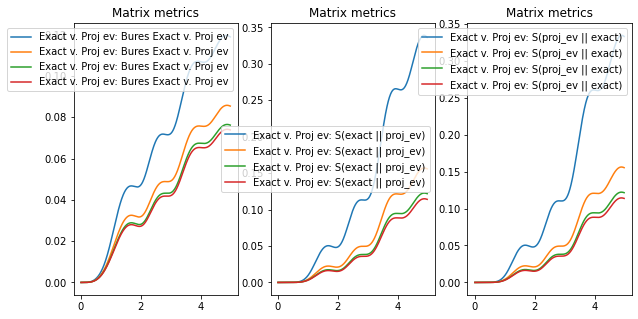

In [114]:
me.plot_exact_v_proj_ev_metrics_multiple(timespan = ts,
                                     range_temps = range_temps,
                                     multiple_evolutions = multiple_ev_results)

In [ ]:
def exact_v_proj_ev_matrix_metrics(timespan, res_proj_ev_rhot_list, res_exact):
    #exact_vn_entropy = [qutip.entropy_vn(rho) for rho in res_exact.states]
    #proj_ev_vn_entropy = [qutip.entropy_vn(rho) for rho in res_proj_ev_rhot_list]
    
    ts_prime = timespan[:-1]
    bures_exact_v_proj_ev_list = bures_vectorized(rhot_list = res_proj_ev_rhot_list,
                                                  sigmat_list = res_exact.states[:-1])
    
    relent_ex_v_proj_ev_list, relent_proj_ev_v_ex = relative_entropies_vectorized(rhot_list = res_proj_ev_rhot_list,
                                                                                  sigmat_list = res_exact.states[:-1])
    
    return bures_exact_v_proj_ev_list, relent_ex_v_proj_ev_list, relent_proj_ev_v_ex

In [100]:
metric_local = exact_v_proj_ev_matrix_metrics_multiple(timespan = timespan, 
                                                           range_temps = range_temps, 
                                                           multiple_evolutions = multiple_ev_results)

In [110]:
metric_local[2]["T0"]

[0.0,
 3.8391684520225596e-16,
 2.5014850836455783e-15,
 3.1972148802580073e-14,
 2.752223133178367e-13,
 1.3862838579708996e-12,
 5.721779116152062e-12,
 1.937775746819902e-11,
 5.60166936123204e-11,
 1.4302000924197296e-10,
 3.307513479688389e-10,
 7.058411949143105e-10,
 1.4093267951604917e-09,
 2.660409580553682e-09,
 4.7875963914679695e-09,
 8.267561465805388e-09,
 1.3772533571647263e-08,
 2.2228999366531726e-08,
 3.488700276779846e-08,
 5.3398607811953836e-08,
 7.991311900192331e-08,
 1.1718464445823731e-07,
 1.68694178330489e-07,
 2.3878674073773596e-07,
 3.3282289939232763e-07,
 4.573509604466981e-07,
 6.202940138139775e-07,
 8.311555184484535e-07,
 1.1012369126465256e-06,
 1.4438716947058714e-06,
 1.8746953845725047e-06,
 2.4119192604607628e-06,
 3.076627544604791e-06,
 3.893067092333735e-06,
 4.888979157788092e-06,
 6.095966178286914e-06,
 7.5498489446748445e-06,
 9.291050146146434e-06,
 1.1364963206974394e-05,
 1.3822385297519724e-05,
 1.671995617985567e-05,
 2.0120600067617

In [ ]:
mutiple_ev_results["init_configs_all"] = multiple_init_configs
        mutiple_ev_results["evs_data_all"] = multiple_evs_data
        mutiple_ev_results["dict_res_proj_ev_all"] = multiple_dict_res_proj_ev
        mutiple_ev_results["res_exact_all"] = multiple_res_exact

Text(0.5, 1.0, 'X_OP')

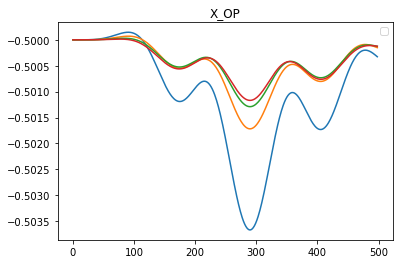

In [7]:
plt.plot(multiple_ev_results["dict_res_proj_ev_all"]["dict_res_proj_ev_T0"]["Avgs"][1])
plt.plot(multiple_ev_results["dict_res_proj_ev_all"]["dict_res_proj_ev_T1"]["Avgs"][1])
plt.plot(multiple_ev_results["dict_res_proj_ev_all"]["dict_res_proj_ev_T2"]["Avgs"][1])
plt.plot(multiple_ev_results["dict_res_proj_ev_all"]["dict_res_proj_ev_T3"]["Avgs"][1])

plt.legend()
plt.title("X_OP")

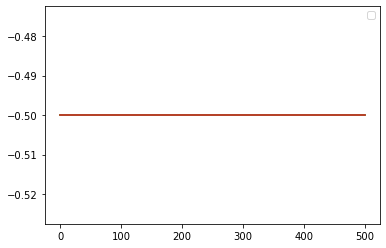

In [34]:
plt.plot(multiple_ev_results["res_exact_all"]["res_exact_T0"].expect[1])
plt.plot(multiple_ev_results["res_exact_all"]["res_exact_T1"].expect[1])
plt.plot(multiple_ev_results["res_exact_all"]["res_exact_T2"].expect[1])
plt.plot(multiple_ev_results["res_exact_all"]["res_exact_T3"].expect[1])

plt.legend()

In [41]:
T = 0.2
multiple_ev_results["res_exact_all"]["res_exact_T" + str(range_temps.index(T))].states

[Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[0.249 0.0 -0.184 0.0]
  [0.0 0.249 0.0 -0.184]
  [-0.184 0.0 0.25 0.0]
  [0.0 -0.184 0.0 0.25]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[ 0.25 +0.j    -0.   +0.j    -0.184-0.006j -0.   +0.j   ]
  [-0.   -0.j     0.25 +0.j    -0.   +0.j    -0.184-0.006j]
  [-0.184+0.006j -0.   -0.j     0.25 +0.j     0.   -0.j   ]
  [-0.   -0.j    -0.184+0.006j  0.   +0.j     0.25 +0.j   ]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[ 0.25 +0.j    -0.   +0.001j -0.184-0.012j -0.   +0.j   ]
  [-0.   -0.001j  0.25 +0.j    -0.   +0.j    -0.184-0.011j]
  [-0.184+0.012j -0.   -0.j     0.25 +0.j     0.   -0.001j]
  [-0.   -0.j    -0.184+0.011j  0.   +0.001j  0.25 +0.j   ]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[ 0.25 +0.j    -0.   +

In [18]:
def plot_exact_v_proj_ev_avgs(obs, labels, timespan, no_cols_desired,
                                                     Result_proj_ev, 
                                                     Result_exact,
                                                     multiple_evolutions,
                                                     range_temps, 
                                                     single_proj_ev = True,
                                                     visualize_diff_expt_vals = False):
    if single_proj_ev:
        multiple_evolutions = None
        range_temps = None
        Tot = len(obs); Cols = no_cols_desired
        Rows = Tot // Cols 
        if Tot % Cols != 0:
            Rows += 1
        Position = range(1,Tot + 1)
        z = timespan[:-1]
        fig = plt.figure(figsize=(18, 14))
        for k in range(Tot):
            ax = fig.add_subplot(Rows,Cols,Position[k])
            if visualize_diff_expt_vals:
                ax.plot(z, Result_exact.expect[k][:-1] - Result_proj_ev[k], label = "Exact diff Proj.ev")
            else:
                ax.plot(z, Result_exact.expect[k][:-1], label = "Exact")
                ax.plot(z, Result_proj_ev[k], label = "Manifold proj")        
            ax.legend(loc=0)
            ax.set_title("Expected values: Proj-ev. v. Exact for " + labels[k])
        plt.show()
        
    else:
        Result_proj_ev = Result_exact = visualize_diff_expt_vals = None
        
        Tot = len(obs); Cols = no_cols_desired
        Rows = Tot // Cols 
        if Tot % Cols != 0:
            Rows += 1
        Position = range(1,Tot + 1)
        z = timespan[:-1]
        fig = plt.figure(figsize=(18, 14))
        range_temps_labels = [i for i in range(len(range_temps))]
        for k in range(Tot):
            ax = fig.add_subplot(Rows, Cols, Position[k])
            ax.plot(z, multiple_ev_results["dict_res_proj_ev_all"]["dict_res_proj_ev_T" + range_temps_labels[k]], label = "Exact")
            ax.plot(z, Result_proj_ev[k], label = "Manifold proj") 
        plt.show()
            
            
        
        
    

In [ ]:
res_exactito = qutip.mesolve(H = H_H, tlist = ts, rho0 = rho_ref, e_ops = observables)
plt.plot(res_exactito.expect[3])

In [12]:
str(range_temps_labels.index(0.2))

NameError: name 'range_temps_labels' is not defined